<a href="https://colab.research.google.com/github/NicolaPasolini/Co2-emission-time-series-forecasting/blob/main/co2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importa librerie e collega drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.pyplot as plt
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import Holt
import numpy as np

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00


In [ ]:
#sistemo dati e grafico andamento nel tempo
table = pd.read_csv('/content/drive/MyDrive/co2/co2.csv')
table = table.loc[table['Entity'] == "World"]
table=table.loc[:, ["Year", "Annual CO₂ emissions"]]
fig = px.line(table, x="Year", y="Annual CO₂ emissions",
        line_shape="spline", render_mode="svg")
table = table.set_index('Year')
table.index = pd.to_datetime(table.index, format='%Y')

serie = table['Annual CO₂ emissions']
table
fig.show()

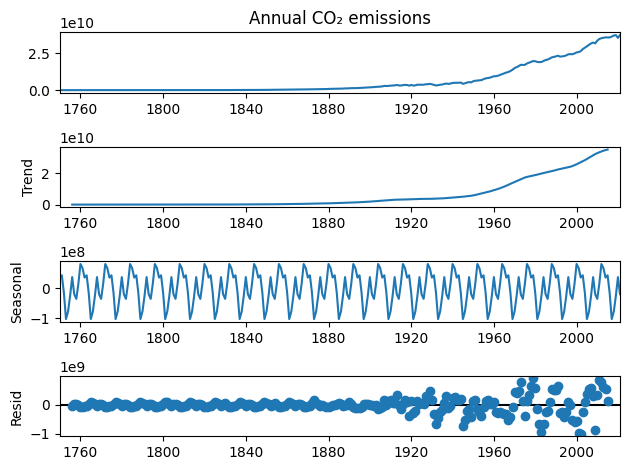

In [ ]:
#analisi statistica andamento: trend
decomposition = sm.tsa.seasonal_decompose(serie, model='additive', filt=None, two_sided=True, period=12)
decomposition.plot()
plt.show()

 > Is the data observed stationary ?
Test statistic = 2.621
P-value = 0.999
Critical values :
	1%: -3.4558530692911504 - The data is not stationary with 99% confidence
	5%: -2.872764881778665 - The data is not stationary with 95% confidence
	10%: -2.572751643088207 - The data is not stationary with 90% confidence


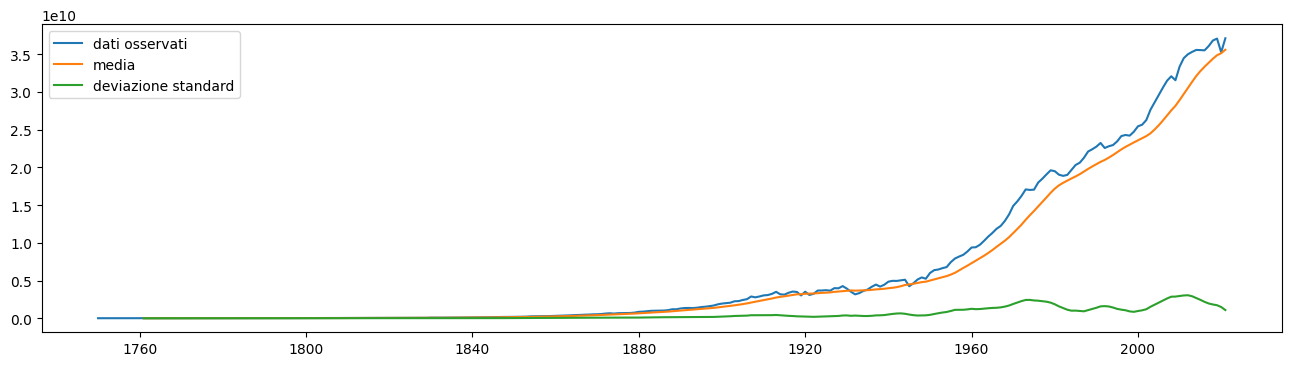

In [ ]:
#analisi stazionarietà dati
#analisi grafica media e varianza (non esaustiva)
def test_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='media');
    ax.plot(rolstd, label='deviazione standard');
    ax.legend()
    pd.options.display.float_format = '{:.8f}'.format
test_stationarity(serie,'dati osservati')

#Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
ADF_test(serie,'data observed')

 > Is the dati rielaborati stationary ?
Test statistic = -3.668
P-value = 0.005
Critical values :
	1%: -3.4583663275730476 - The data is  stationary with 99% confidence
	5%: -2.8738660999177132 - The data is  stationary with 95% confidence
	10%: -2.5733390785693766 - The data is  stationary with 90% confidence


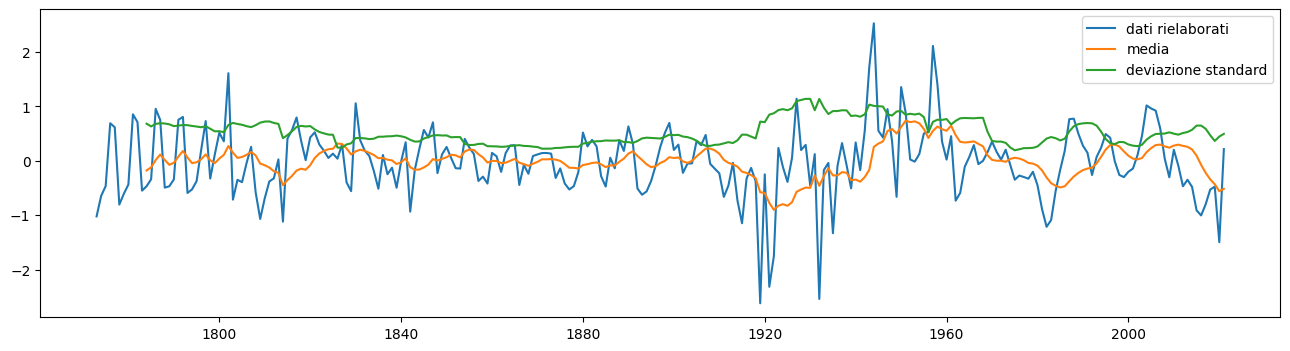

In [ ]:
#rendo dati stazionari
serie_detrend =  (serie - serie.rolling(window=12).mean())/serie.rolling(window=12).std()
serie_12lag_detrend =  serie_detrend - serie_detrend.shift(12)
test_stationarity(serie_12lag_detrend,'dati rielaborati')
ADF_test(serie_12lag_detrend,'dati rielaborati')

In [ ]:
#dividi dati addestramento e validazione 80/20
y_to_train = serie[:'1966-01-01']
y_to_val = serie['1967-01-01':]
previsione=30

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



The Root Mean Squared Error of Holts Linear trend 1227886375.61
The Root Mean Squared Error of Holts Exponential trend 8436289816.65


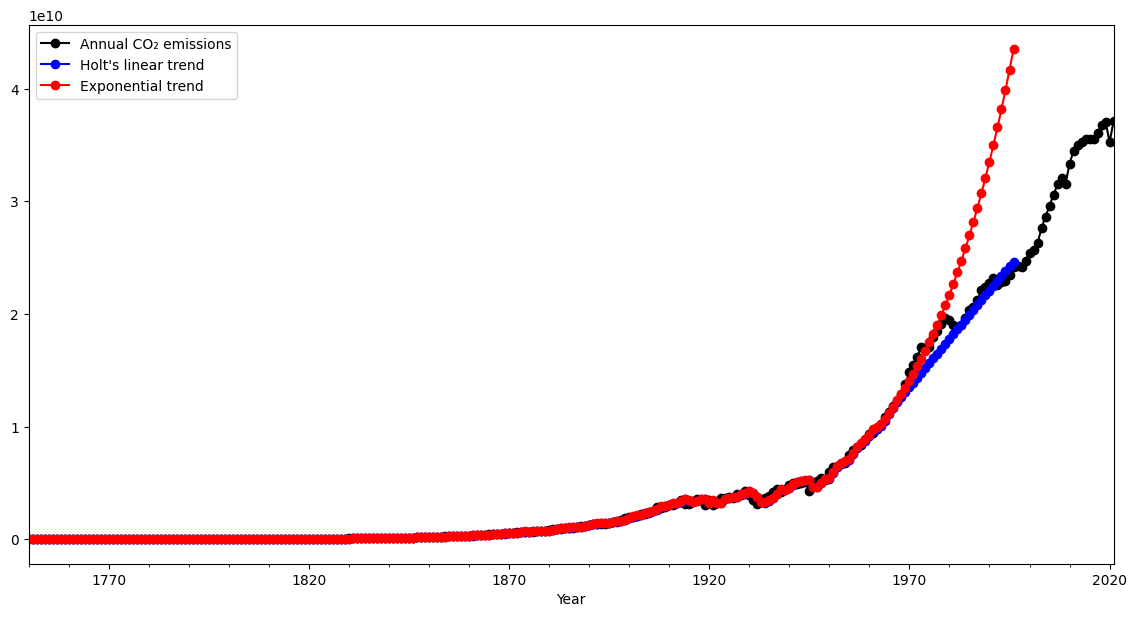

In [ ]:
#modello holt
def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))
    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)
    plt.show()

holt(serie, y_to_train,y_to_val,0.6,0.2,previsione)

In [ ]:
#validazione arima: metodo per scoprire i giusti parametri da usare
stepwise_model = auto_arima(serie, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=11009.132, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=10963.160, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=10938.375, Time=0.54 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=11006.960, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=10938.105, Time=1.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=10963.690, Time=0.66 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=10937.529, Time=2.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=10945.556, Time=1.46 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=10937.660, Time=9.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=10937.304, Time=4.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=10936.618, Time=2.00 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=10962.422, Time=1.35 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=10921.185, Time=9.32 sec
 ARIMA(1,1,

In [ ]:
prophet = table.reset_index()
prophet = prophet.rename(columns={'Year': 'ds' , 'Annual CO₂ emissions': 'y'})
#del prophet['index']
prophet

,ds,y
0,1750-01-01,9.350528e+06
1,1751-01-01,9.350528e+06
2,1752-01-01,9.354192e+06
3,1753-01-01,9.354192e+06
4,1754-01-01,9.357856e+06
...,...,...
267,2017-01-01,3.609674e+10
268,2018-01-01,3.682651e+10
269,2019-01-01,3.708256e+10
270,2020-01-01,3.526409e+10


In [ ]:
from prophet import Prophet

# Creating an instance of the Prophet class and training the model
m = Prophet() #instantiating a new Prophet object
model = m.fit(prophet) #build the model with the historical data

future = model.make_future_dataframe(periods=30, freq='D') #build the dataframe containing the predictions (and the historical data with the model fit)
forecast = model.predict(future) #The forecast object here is a new dataframe that includes a column yhat with the forecast

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp87rotl98/xvay_lvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp87rotl98/sm5bkdje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49360', 'data', 'file=/tmp/tmp87rotl98/xvay_lvk.json', 'init=/tmp/tmp87rotl98/sm5bkdje.json', 'output', 'file=/tmp/tmp87rotl98/prophet_modelipfefmrp/prophet_model-20230728104624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
297,2021-01-27,4.499477e+10,4.420159e+10,4.573074e+10
298,2021-01-28,4.408765e+10,4.329362e+10,4.486431e+10
299,2021-01-29,4.310123e+10,4.233122e+10,4.380860e+10
300,2021-01-30,4.205769e+10,4.127800e+10,4.284863e+10
301,2021-01-31,4.098042e+10,4.025612e+10,4.173553e+10


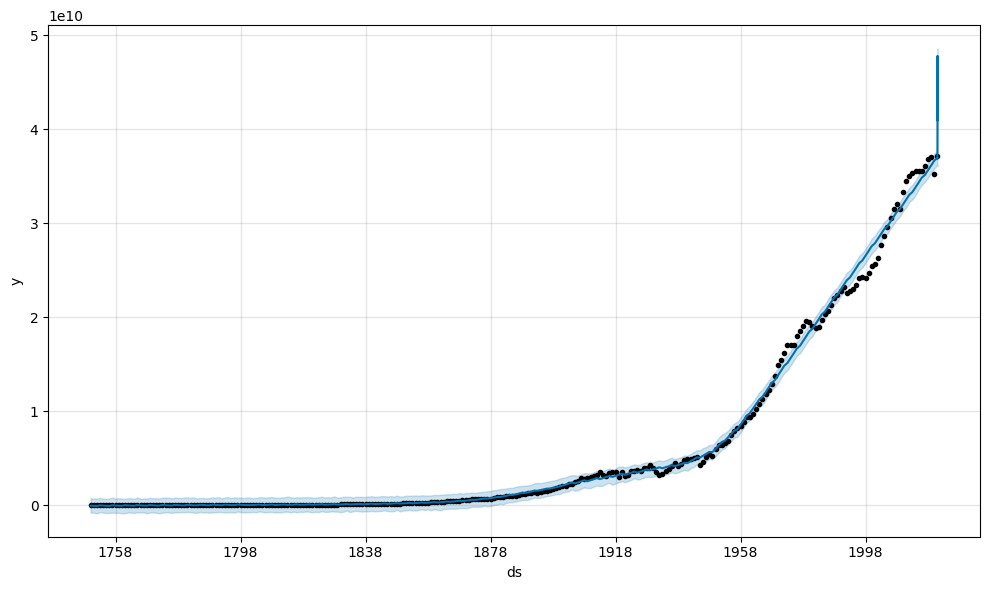

In [ ]:
plot1 = model.plot(forecast, uncertainty=True)

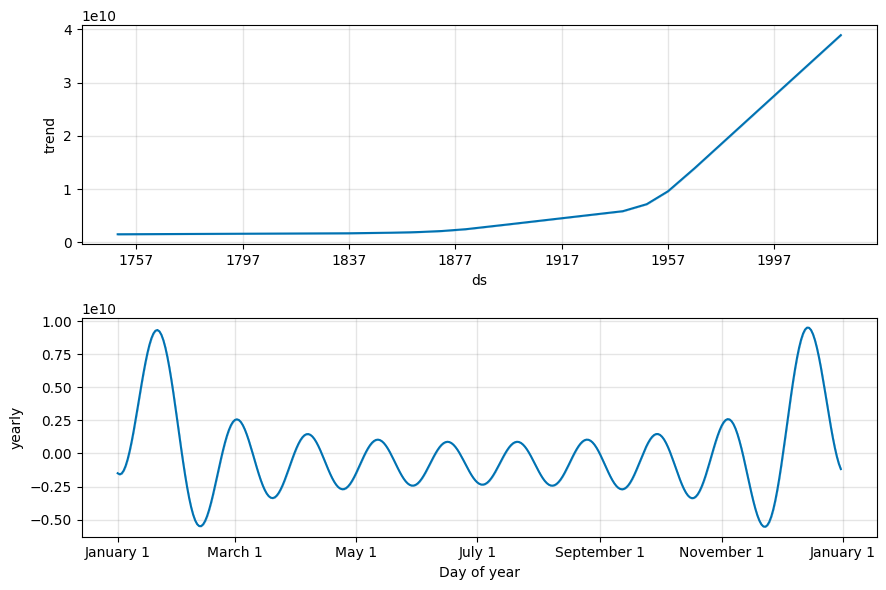

In [ ]:
plot2 = model.plot_components(forecast)